In [11]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from mediapipe.python.solutions.drawing_utils import draw_landmarks
from mediapipe.python.solutions import drawing_styles
import numpy as np
import pandas as pd

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from util import mediapipe_utils
from util import opencv_utils

import importlib
importlib.reload(mediapipe_utils)
importlib.reload(opencv_utils)

from util.mediapipe_utils import *
from util.opencv_utils import *

%load_ext autoreload
%autoreload 2

# Daniel Path
# video_path = r"C:\Users\User\OneDrive\Documents\Projects\Lip-Reading\GRID\s1\s1\bbaf2n.mpg"
# Ryan Path
# video_path = r"C:\Projects\Lip_Reading\GRID\s1\bbaf2n.mpg"



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Isolate lip landmarks and coordinates
# Outer lips (full loop)
outer_lips = [
    61, 146, 91, 181, 84, 17,
    314, 405, 321, 375, 291, 409, 
    270, 269, 267, 0, 37, 39, 40, 185
]

# Inner lips (inside mouth opening)
inner_lips = [
    78, 95, 88, 178, 87, 
    14, 317, 402, 318, 324, 
    308, 415, 310, 311, 312, 
    13, 82, 81, 80, 191
]

inner_mouth = [
    184, 183, 74, 42, 73, 41, 72, 38,
    11, 12, 302, 268, 303, 271, 304, 272,408,
    407, 96, 77, 89, 90, 179, 180, 86, 85, 15, 
    16, 316, 315, 403, 404, 319, 320, 325, 307
]

lower_jaw = [
    148, 152, 377
]

In [13]:
def setup_landmarks(frame):
    # Crop and proccess landmarks
    landmarks = get_landmarks(frame)[0] # 0 being the first face found
    coords = convert_landmarks_to_coordinates(landmarks, frame.shape)
    x_min, y_min, x_max, y_max = get_bounding_box(coords, frame.shape)
    cropped_frame = frame[int(y_min):int(y_max), int(x_min):int(x_max)]
    
    cropped_landmarks = get_landmarks(cropped_frame)[0]
    coords = convert_landmarks_to_coordinates(cropped_landmarks, cropped_frame.shape)
    
    return (cropped_landmarks, coords)

def fast_setup_landmarks(frame):
    #MAYBE FASTER AND TRADE OFF: ONLY PROCCESS
    landmarks = get_landmarks(frame)[0] 
    coords = convert_landmarks_to_coordinates(landmarks, frame.shape)
    
    return (landmarks, coords)


In [14]:
# Normalized Features
# Divide by dimensions of cropped face to account for face sizes 
# Use face height and eye distance as normailization metrics
    
def normalize_vertical_measurements(coords, measurements):
    face_height = landmark_dist(coords[10], coords[152])
    return [m/face_height for m in measurements]

def normalize_horizontal_measurements(coords, measurements):
    eye_dist = landmark_dist(coords[133], coords[362])
    return [m/eye_dist for m in measurements]

def normalize_area(coords, measurements):
    face_height = landmark_dist(coords[10], coords[152])
    eye_dist = landmark_dist(coords[133], coords[362])
    return [m/(face_height*eye_dist) for m in measurements]
    

In [15]:
def get_primary_measurements(frame):

    landmarks, coords = setup_landmarks(frame)
    
    upper_vermillion_height = landmark_dist(coords[13], coords[0])
    lower_verillion_height = landmark_dist(coords[14], coords[17])

    vert_distance = landmark_dist(coords[13], coords[14])
    hori_distance = landmark_dist(coords[308], coords[78])
    aspect_ratio = hori_distance/vert_distance

    lower_jaw_distance = landmark_dist(coords[14], coords[152])

    inner_mouth_area = abs(area_of_points(inner_lips, coords))
    outer_mouth_area = abs(area_of_points(outer_lips, coords))

    norm_uvh, norm_lvh, norm_vd, norm_jd = normalize_vertical_measurements(coords, [upper_vermillion_height,lower_verillion_height,vert_distance,lower_jaw_distance])
    norm_hd, = normalize_horizontal_measurements(coords, [hori_distance])
    norm_ar = norm_hd/norm_vd
    norm_ima, norm_oma = normalize_area(coords, [inner_mouth_area, outer_mouth_area])

    return [
        upper_vermillion_height,
        lower_verillion_height,
        vert_distance,
        hori_distance,
        aspect_ratio,
        lower_jaw_distance,
        inner_mouth_area,
        outer_mouth_area,
        norm_uvh,
        norm_lvh,
        norm_vd,
        norm_hd,
        norm_ar,
        norm_jd,
        norm_ima,
        norm_oma
    ]

In [16]:
# Get Avgeraged Measurements
# Average over 3 frames to get a more stable measurement

# [upper_vermillion_height, lower_vermillion_height, vert_distance, hori_distance, aspect_ratio, lower_jaw_distance, inner_mouth_area, outer_mouth_area]
# [norm_uvh, norm_lvh, norm_vd, norm_hd, norm_ar, norm_jd, norm_ima, norm_oma]
def get_average_resting(video_path):
    avg_features = [0]*16
    frames = load_video(video_path)
    for i in range(3): # Average of first three frames
        frame = frames[i]
        vals = get_primary_measurements(frame)
        for j in range(16):
            avg_features[j] += vals[j]
    return [x / 3 for x in avg_features]



In [17]:
def get_frame_measurement(frame, data_table , average_resting_vals, frame_number):    
    # Primary measurements
    upper_vermillion_height,lower_verillion_height,vert_distance,hori_distance,aspect_ratio,lower_jaw_distance,inner_mouth_area,outer_mouth_area,norm_uvh,norm_lvh,norm_vd,norm_hd,norm_ar,norm_jd,norm_ima,norm_oma = get_primary_measurements(frame)
    
    landmarks, coords = setup_landmarks(frame)
    
    # Temporal landmarks and scientific - engineered landmarks

        # Vertical Lip Compression
        # - Measures how "pursed" the lips are
        
        # Corner Displacement
        # - Measures how tightened mouth is
        
        # Key Landmark Velocities 
        # - Track velocity of key landmarks using x2-x1 / t2-t1, such as lip corners, top and bottom of inner edge of lip, etc.

    if(frame_number == 0): # no temporal data for frame 0 due to backwards finite difference -> assume at rest
        vert_lip_compression = 0
        corner_displacement = 0
    else:
        vert_lip_compression = (upper_vermillion_height + lower_verillion_height) / (average_resting_vals[0] + average_resting_vals[1])
        corner_displacement = hori_distance / average_resting_vals[3]    

    norm_vlc, = normalize_vertical_measurements(coords, [vert_lip_compression])
    norm_cd, = normalize_horizontal_measurements(coords, [corner_displacement])
    
    if frame_number == 0:
        lip_corner_velocity = 0
        top_inner_lip_velocity = 0
        bottom_inner_lip_velocity = 0
    else:
        lip_corner_velocity = hori_distance - data_table[frame_number - 1][3] 
        top_inner_lip_velocity = upper_vermillion_height - data_table[frame_number - 1][0]
        bottom_inner_lip_velocity = lower_verillion_height - data_table[frame_number - 1][1]
    
    return([
        frame_number,
        float(upper_vermillion_height),
        float(lower_verillion_height),
        float(vert_distance),
        float(hori_distance),
        float(aspect_ratio),
        float(lower_jaw_distance),
        float(inner_mouth_area),
        float(outer_mouth_area),
        float(norm_uvh),
        float(norm_lvh),
        float(norm_vd),
        float(norm_hd),
        float(norm_ar),
        float(norm_jd),
        float(norm_ima),
        float(norm_oma),
        float(norm_vlc),
        float(norm_cd),
        float(vert_lip_compression),
        float(norm_vlc),
        float(corner_displacement),
        float(norm_cd),
        float(lip_corner_velocity),
        float(top_inner_lip_velocity),
        float(bottom_inner_lip_velocity)
    ])


In [18]:
def fetch_refined(frame, previous_data, frame_number):    
    # Primary, normalized measurements
    landmarks, coords = setup_landmarks(frame)
    
    upper_vermillion_height = landmark_dist(coords[13], coords[0])
    lower_verillion_height = landmark_dist(coords[14], coords[17])

    vert_distance = landmark_dist(coords[13], coords[14])
    hori_distance = landmark_dist(coords[308], coords[78])

    lower_jaw_distance = landmark_dist(coords[14], coords[152])

    inner_mouth_area = abs(area_of_points(inner_lips, coords))
    outer_mouth_area = abs(area_of_points(outer_lips, coords))

    norm_uvh, norm_lvh, norm_vd, norm_jd = normalize_vertical_measurements(coords, [upper_vermillion_height,lower_verillion_height,vert_distance,lower_jaw_distance])
    norm_hd, = normalize_horizontal_measurements(coords, [hori_distance])
    norm_ima, norm_oma = normalize_area(coords, [inner_mouth_area, outer_mouth_area])
    
    if(frame_number == 0): # no temporal data for frame 0 due to backwards finite difference -> assume at rest
        vert_lip_compression = 0
        corner_displacement = 0
    else:
        vert_lip_compression = (upper_vermillion_height + lower_verillion_height) / (previous_data[0][0]['norm_uvh'] + previous_data[0][0]['norm_lvh'])
        corner_displacement = hori_distance / previous_data[0][0]['norm_hd']

    norm_vlc, = normalize_vertical_measurements(coords, [vert_lip_compression])
    norm_cd, = normalize_horizontal_measurements(coords, [corner_displacement])
    
    
    # Individual Landmark Velocities and landmarks 2 Dimensional
    # Normalize coordingates first to consistent origin - midpt of eyes
    eye_midpt = (((coords[133][0] + coords[362][0])/2), ((coords[133][1] + coords[362][1])/2))
    norm_coords = [((coord[0]-eye_midpt[0]),(coord[1]-eye_midpt[1])) for coord in coords]
    key_landmarks_index = [78, 308, 13, 14, 152, 311, 81, 402, 178] 
    
    key_norm_coords = {f"l_{i}":norm_coords[i] for i in key_landmarks_index}
    

    velocities = {}
    if frame_number == 0:
        velocities = {f"l_{i}": 0 for i in key_landmarks_index}
    else:
        for i in key_landmarks_index:
            v_x = (norm_coords[i][0] - previous_data[frame_number - 1][1][i][0])
            v_y = (norm_coords[i][1] - previous_data[frame_number - 1][1][i][1])  
            velocities[f"l_{i}"] = (v_x,v_y)
    
    # Engineered Feature Velocities - 1 Dimensional
    if frame_number == 0:
        norm_vert_opening_velocity = 0
        norm_hori_opening_velocity = 0
    else:
        norm_vert_opening_velocity = norm_vd - previous_data[frame_number - 1][0]['norm_vd']
        norm_hori_opening_velocity = norm_hd - previous_data[frame_number - 1][0]['norm_hd'] # lip corner velocity 
    
    engineered_features = {
        'frame_number': frame_number,
        'norm_uvh': norm_uvh,
        'norm_lvh': norm_lvh,
        'norm_vd': norm_vd,
        'norm_hd': norm_hd,
        'norm_jd': norm_jd,
        'norm_ima': norm_ima,
        'norm_oma': norm_oma,
        'norm_vlc': norm_vlc,
        'norm_cd_1': norm_cd,
        'norm_vert_opening_velocity': norm_vert_opening_velocity,
        'norm_hori_opening_velocity': norm_hori_opening_velocity,
    }
    
    # return 3 dictionaries (used in ML) and one list (used for calcs)
    return [engineered_features, key_norm_coords, velocities, norm_coords]
    


    


In [19]:
# Make 2D array of measurements
# Each row is a frame, each column is a measurement
video_path = r"C:\Projects\Lip_Reading\GRID\s1\bbaf2n.mpg"

cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

previous_data = [] 
engineered_features = []
landmark_coordinates = []
landmark_velocities = []

frames = load_video(video_path)
for i in range(total_frames):
    frame = frames[i]
    frame_data = fetch_refined(frame, previous_data, i)
    
    previous_data.append((frame_data[0], frame_data[3]))
    engineered_features.append(frame_data[0])
    landmark_coordinates.append(frame_data[1])
    landmark_velocities.append(frame_data[2])
    

df1 = pd.DataFrame(engineered_features)
df2 = pd.DataFrame(landmark_coordinates)
df3 = pd.DataFrame(landmark_velocities)
df1.to_csv("engineered_features.csv")
df2.to_csv("landmark_coordinates.csv")
df3.to_csv("landmark_velocities.csv")



    



In [20]:
# Inspect Frame for validation of notebook
x = 1
rgb_frame = load_video(video_path)[x]
image_shape = rgb_frame.shape

plt.imshow(rgb_frame)
plt.title(f"Frame {x}")
plt.axis(False)
plt.show()


IndexError: list index out of range

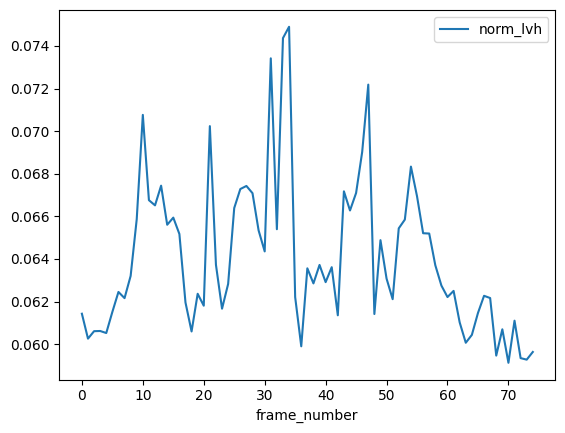

In [ ]:
# Plotting data to visualize outliers
# Replace y with valid column names
df1.plot(x= 'frame_number', y='norm_lvh' ,kind= 'line')
plt.show()